# Risk forecasting DNN model

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from time import time

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
SERIES_PERIOD = 'max'
SERIES_INTERVAL = '1d'

LOOKBACK_WINDOW = 10
PREDICTION_LEN = 1
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.9

EPOCHS = 20
BATCH_SIZE = 32

ACTIVE_LEARNING = False
AL_ITERATIONS = 50
AL_SAMPLE = 100
AL_EPOCHS = 1

PROGRESSIVE_LEARNING = False
PRETRAINING_EPOCHS = 10

### Dataset

In [ ]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# gather other variables
_open = sp500_history.Open[:-1]
_high = sp500_history.High[:-1]
_low = sp500_history.Low[:-1]
_volume = sp500_history.Volume[:-1]

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'close': (close - close.min()) / close.max(),
    'returns': log_returns / log_returns.max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X = X[list(X)].astype(np.float64)
X

,open,high,low,volume,close,returns,volatility
Date,,,,,,,
1950-01-10,0.003545,0.000077,0.000077,0.000129,0.000077,-0.026755,0.041578
1950-01-11,0.003557,0.000089,0.000090,0.000170,0.000090,0.032097,0.026233
1950-01-12,0.003488,0.000021,0.000021,0.000200,0.000021,-0.177951,0.085538
1950-01-13,0.003470,0.000002,0.000002,0.000231,0.000002,-0.049140,0.082654
1950-01-16,0.003480,0.000012,0.000013,0.000068,0.000013,0.027332,0.077147
...,...,...,...,...,...,...,...
2022-06-10,0.827221,0.821341,0.812441,0.343520,0.809789,-0.269617,0.141649
2022-06-13,0.798864,0.793067,0.777742,0.399096,0.778260,-0.360858,0.159306
2022-06-14,0.783331,0.780622,0.771755,0.360129,0.775310,-0.034505,0.118952


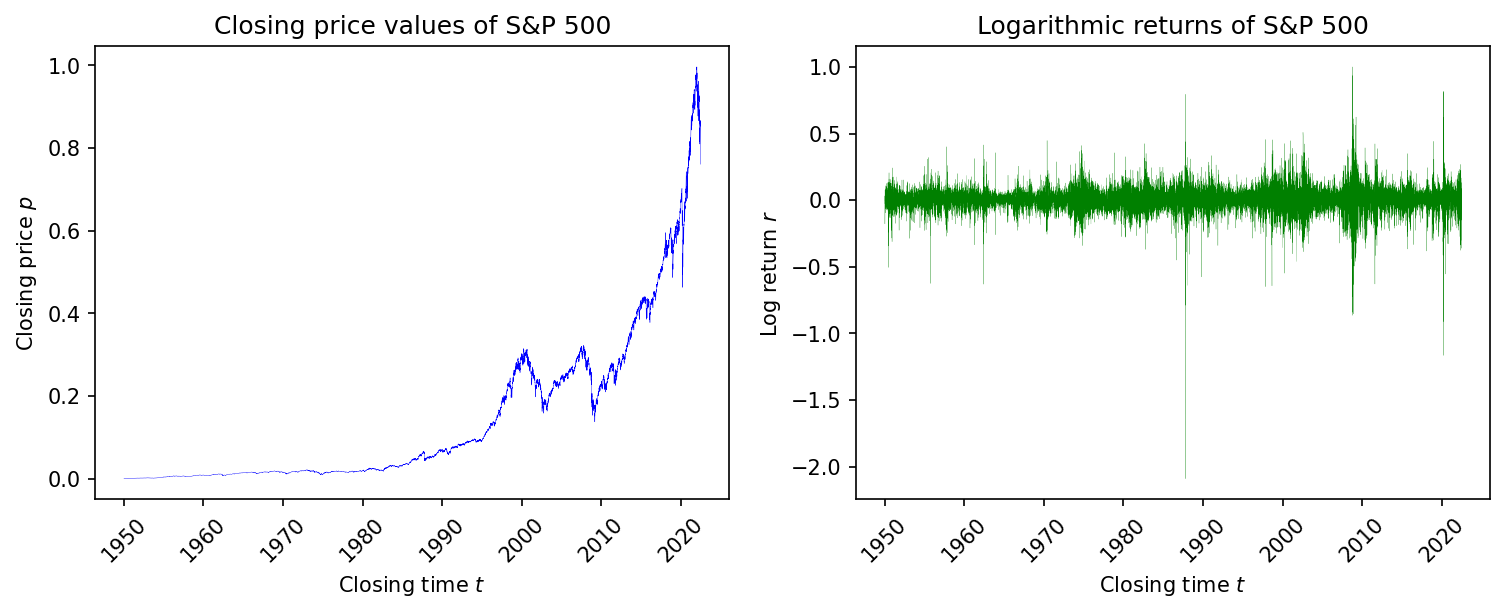

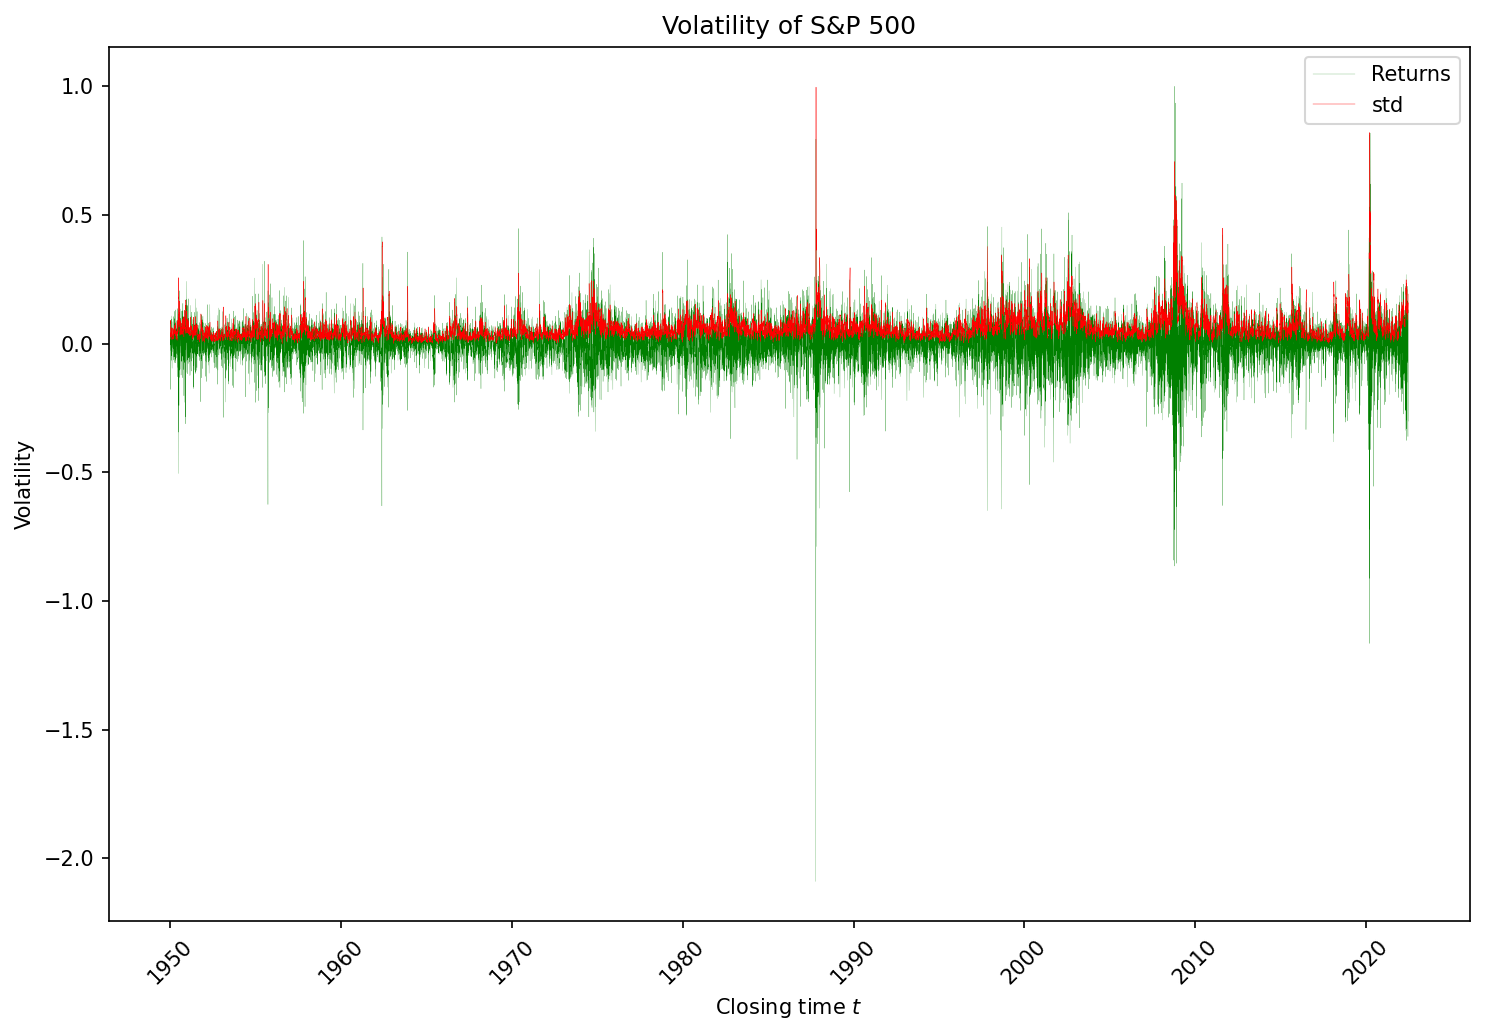

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.1, color='g', label='Returns')
ax.plot(X.volatility, linewidth=0.2, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW - PREDICTION_LEN):
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + PREDICTION_LEN])

# convert X, y to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

X_train, y_train = shuffle(X_train, y_train)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print("Train:", X_train.shape, y_train.shape, '\nTest: ', X_test.shape, y_test.shape)

90% training data, 10% testing data
Train: (16395, 10, 7) (16395, 1) 
Test:  (1822, 10, 7) (1822, 1)


### Unsupervised layer-wise training

In [ ]:
# unsupervised layer-wise training
def base_autoencoder(X, test_X):
    # define base model
    model = Sequential([
        LSTM(32, activation='tanh', return_sequences=True, input_shape=(X.shape[1:])),
        TimeDistributed(Dense(X.shape[2]))
    ])

    # compile base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mse', optimizer=optim)

    # train model as an autoencoder that recreates its inputs (minimising mse between input and ouput)
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    # evaluate autoencoder
    _acc = model.evaluate(test_X, test_X)

    return model, hist.history, _timer, _acc


def convert_to_regressor(model, X, y):
    # remove the output layer corresponding to the autoencoder
    output = model.layers[-1]
    model.pop()

    # fix weights of autoencoder layers
    for l in model.layers: l.trainable = False

    # add new output layer for regression
    model.add(LSTM(32, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train the output layer to predict a regression between inputs and outputs
    model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    return model, output


def evaluate_regression(model, X, y, test_X, test_y):
    # convert autoencoder model to regression model (outputs regression X->y instead of recreation of inputs)
    model, output_layer = convert_to_regressor(model, X, y)

    # evaluate model as a regressor
    _, _acc = model.evaluate(test_X, test_y)

    # reassemble original autoencoder model
    model.pop()
    model.add(output_layer)
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mse', optimizer=optim)

    return model, _acc


def add_autoencoder(model, X, test_X):
    # stash output layer
    output = model.layers[-1]
    model.pop()

    # fix weights of autoencoder layers (note, this is redundant if `evaluate_regression` called beforehand)
    for l in model.layers: l.trainable = False

    # add new autoencoder layer and read output layer
    model.add(LSTM(32, activation='tanh', return_sequences=True))
    model.add(output)

    # train new autoencoder layer
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    # evaluate autoencoder
    _acc = model.evaluate(test_X, test_X)

    return model, hist.history, _timer, _acc


def build_final_model(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(LSTM(32, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    # train regressor
    history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    return model, history.history

In [ ]:
encoder, history_prog, total_time_prog, autoencoder_acc_1 = base_autoencoder(X_train, X_test)
# model, regressor_acc_1 = evaluate_regression(model, X_train, y_train, X_test, y_test)

encoder, history_prog_2, timer, autoencoder_acc_2 = add_autoencoder(encoder, X_train, X_test)
# model, regressor_acc_2 = evaluate_regression(model, X_train, y_train, X_test, y_test)

regressor, history_regressor = build_final_model(encoder, X_train, y_train)

Epoch 1/10
52/52 [==============================] - 3s 27ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 2/10
52/52 [==============================] - 1s 28ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 3/10
52/52 [==============================] - 1s 29ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/10
52/52 [==============================] - 1s 28ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/10
52/52 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 8.7684e-04
Epoch 6/10
52/52 [==============================] - 1s 20ms/step - loss: 7.4617e-04 - val_loss: 6.1240e-04
Epoch 7/10
52/52 [==============================] - 1s 28ms/step - loss: 5.1993e-04 - val_loss: 4.2936e-04
Epoch 8/10
52/52 [==============================] - 1s 21ms/step - loss: 3.7656e-04 - val_loss: 3.2561e-04
Epoch 9/10
52/52 [==============================] - 1s 20ms/step - loss: 2.9409e-04 - val_loss: 2.6025e-04
Epoch 10/10
57/57 [==============================] - 0s 2ms/step - loss: 

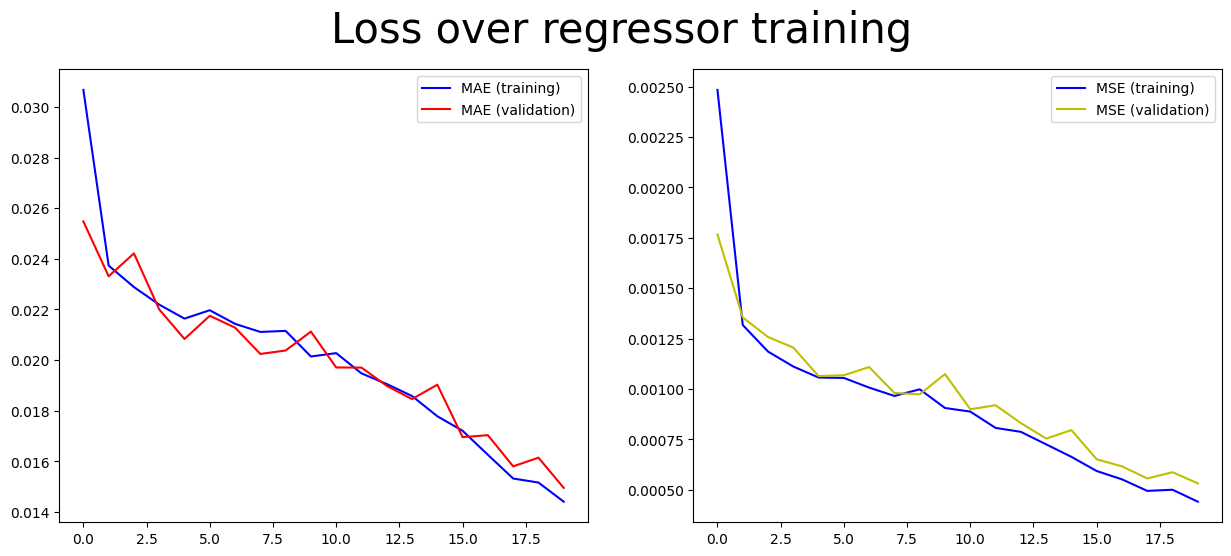

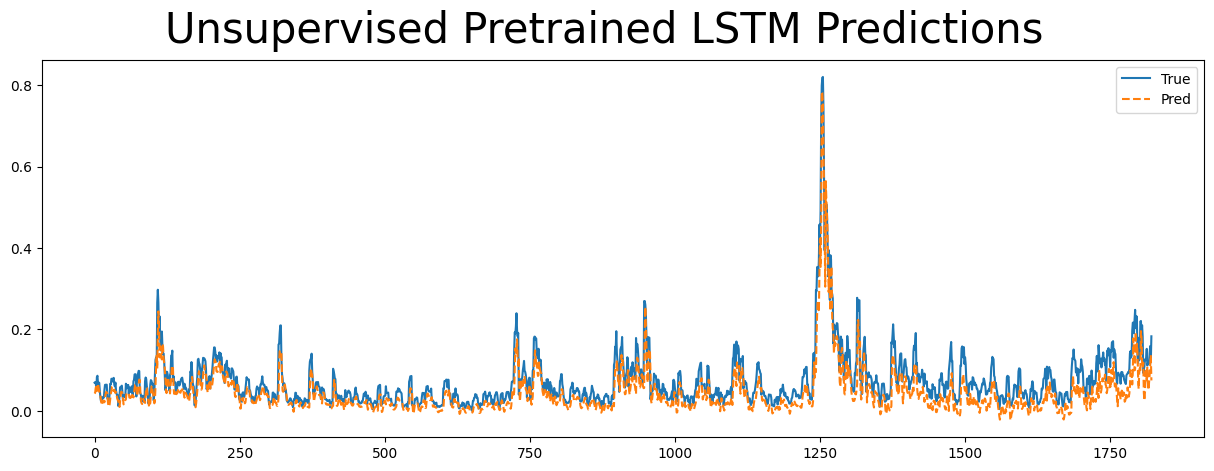

In [ ]:
# loss plots
mae, val_mae = history_regressor['loss'], history_regressor['val_loss']
mse, val_mse = history_regressor['mse'], history_regressor['val_mse']

fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
fig.suptitle("Loss over regressor training", fontsize=30)

ax[0].plot(mae, color='b', label="MAE (training)")
ax[0].plot(val_mae, color='r', label="MAE (validation)")
ax[0].legend(loc=0)

ax[1].plot(mse, color='b', label="MSE (training)")
ax[1].plot(val_mse, color='y', label="MSE (validation)")
ax[1].legend(loc=0)

# prediction plot
y_pred = regressor.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
fig.suptitle("Unsupervised Pretrained LSTM Predictions", fontsize=30)

ax.plot(y_test, label='True')
ax.plot(y_pred, linestyle='--', label='Pred')
ax.legend(loc=0)

In [ ]:
mae = np.abs(np.subtract(y_test, y_pred)).mean()
mse = np.square(np.subtract(y_test, y_pred)).mean()
mape = np.abs((y_test - y_pred) / y_test).mean() * 100

_msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(y_pred + 1)))
_msle.dropna(inplace=True)
msle = float(np.square(_msle).mean())

print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")

mae = 0.02938; mse = 0.00147; msle = 0.00120; mape = 49.40697%


**Fixed pre-trained layers**

*Run 1:*
- mae = 0.02306; mse = 0.00141; msle = 0.00097; mape = 42.57247%

*Run 2:*
- mae = 0.02928; mse = 0.00154; msle = 0.00127; mape = 53.73176%

*Run 3:*
- mae = 0.02938; mse = 0.00147; msle = 0.00120; mape = 49.40697%

**Tunable pre-trained layers**

*Run 1:*
- mae = 0.01670; mse = 0.00065; msle = 0.00048; mape = 38.83693%

*Run 2:*
- mae = 0.01549; mse = 0.00059; msle = 0.00044; mape = 29.10859%

### Supervised layer-wise training (and comparison model)

In [ ]:
# supervised progressive training
def base_model(X, y):
    # define base model
    model = Sequential([
        LSTM(5, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        Dense(1, activation='linear')
    ])
    
    # compile and train base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    _start = time()
    hist = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


def progress_layers(model, X, y, history, ret_seq=False):
    # save then remove output layer
    output = model.layers[-1]
    model.pop()

    # halt training on existing layers
    for l in model.layers: l.trainable = False

    # add new layer and restore output layer
    model.add(
        LSTM(5, return_sequences=ret_seq, activation='tanh')
    )
    model.add(output)

    # retrain newest layer (+ output layer)
    _start = time()
    hist = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])
    history['mse'].extend(hist.history['mse'])
    history['val_mse'].extend(hist.history['val_mse'])

    return model, history, _timer


model, history_prog, total_time_prog = base_model(X_train, y_train)
test_loss_1, test_acc_1 = model.evaluate(X_test, y_test)

model, history_prog, timer = progress_layers(model, X_train, y_train, history_prog, ret_seq=True)
total_time_prog += timer
test_loss_2, test_acc_2 = model.evaluate(X_test, y_test)

model, history_prog, timer = progress_layers(model, X_train, y_train, history_prog, ret_seq=False)
total_time_prog += timer
test_loss_3, test_acc_3 = model.evaluate(X_test, y_test)

In [ ]:
print(f"\nMAE: {test_loss_1:.4f} -> {test_loss_2:.4f} -> {test_loss_3:.4f}, min train = {min(history_prog['loss']):.4f}, min val = {min(history_prog['val_loss']):.4f}")
print(f"MSE: {test_acc_1:.4f} -> {test_acc_2:.4f} -> {test_acc_3:.4f}, min = {min(history_prog['mse']):.4f}, min val = {min(history_prog['val_mse']):.4f}")
print(f"training time = {total_time_prog:.2f}s \n")

print(model.summary())

fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
fig.suptitle("Loss and MSE", fontsize=30)

ax[0].plot(history_prog['loss'], color='b', label="loss (training)")
ax[0].plot(history_prog['val_loss'], color='g', label="loss (validation)")
ax[0].legend(loc=0)

ax[1].plot(history_prog['mse'], color='r', label="MSE (training)")
ax[1].plot(history_prog['val_mse'], color='y', label="MSE (validation)")
ax[1].legend(loc=0)

In [ ]:
# comparative model to progressively trained model
comp_model = Sequential([
    LSTM(5, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(5, return_sequences=True, activation='tanh'),
    LSTM(5, activation='tanh'),
    Dense(1, activation='linear')
])

# compile and train comparison model
optim = Adam(learning_rate=0.001, decay=1e-5)
comp_model.compile(loss='mae', optimizer=optim, metrics=['mse'])

# train and evaluate 
start_comp = time()
hist = comp_model.fit(X_train, y_train, epochs=3*EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
total_time_comp = time() - start_comp
history_comp = hist.history

test_loss, test_acc = comp_model.evaluate(X_test, y_test)

In [ ]:
print(f"\nMAE: final = {test_loss:.4f}, min = {min(history_comp['loss']):.4f}, min val = {min(history_comp['val_loss']):.4f}")
print(f"MSE: {test_acc:.4f}, min = {min(history_comp['mse']):.4f}, min val = {min(history_comp['val_mse']):.4f}")
print(f"training time = {total_time_comp:.2f}s \n")

print(comp_model.summary())

fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
fig.suptitle("Loss and MSE", fontsize=30)

ax[0].plot(history_comp['loss'], color='b', label="loss (training)")
ax[0].plot(history_comp['val_loss'], color='g', label="loss (validation)")
ax[0].legend(loc=0)

ax[1].plot(history_comp['mse'], color='r', label="MSE (training)")
ax[1].plot(history_comp['val_mse'], color='y', label="MSE (validation)")
ax[1].legend(loc=0)

### Previous work

In [7]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

models = {
    'LSTM': lstm_model
}

adam_opt = Adam(learning_rate=0.001, decay=1e-5)

for model in models.values():
    model.compile(loss='mae', optimizer=adam_opt, metrics=['mse'])

In [8]:
# GSx sampling for initial seed pool
def initial_selection(X, y, k=AL_SAMPLE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(X, axis=0)

    # compute euclidean distance
    distances = np.max(np.linalg.norm(X - centroid, axis=2), axis=1)

    # select instances with smallest distance
    train_indices = np.argpartition(distances, k)[:k]
    X_instances = X[train_indices]
    y_instances = y[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(X.shape[0]), train_indices)
    X_instances_val = X[val_indices]
    y_instances_val = y[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


# GSy sampling for selecting instances to add to training pool
def select_instances(model, X_t, y_t, X_v, y_v, k=AL_SAMPLE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.squeeze(1)
    _y_t = y_t.squeeze(1)
    distances = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distances, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v

In [16]:
# train each model
histories = {}
for m in range(len(models)):
    model = list(models.values())[m]
    model_name = list(models.keys())[m]

    # active learning training
    if ACTIVE_LEARNING:
        print("Active Learning Method...")
        # initial training over seed dataset
        X_pool, y_pool, X_val, y_val = initial_selection(X_train, y_train)
        history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)

        # store metrics
        histories.update({
            model_name: {
                'loss': [np.min(history.history['loss'])],
                'mse': [np.min(history.history['mse'])],
                'val_loss': [np.min(history.history['val_loss'])],
                'val_mse': [np.min(history.history['val_mse'])]
            }
        })

        # iteratively train model
        for it in range(AL_ITERATIONS):
            print(f"Iteration {it}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
            if X_val.shape[0] >= AL_SAMPLE:
                # use GSy method to select samples to add to the training pool
                X_pool, y_pool, X_val, y_val = select_instances(lstm_model, X_pool, y_pool, X_val, y_val)

                # train model over pool
                history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
                
                # store metrics
                histories[model_name]['loss'].append(np.min(history.history['loss']))
                histories[model_name]['mse'].append(np.min(history.history['mse']))
                histories[model_name]['val_loss'].append(np.min(history.history['val_loss']))
                histories[model_name]['val_mse'].append(np.min(history.history['val_mse']))
            else:
                break
    # baseline training process
    else:
        print("Basic Training Method...")
        history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
        histories.update({
            model_name: history.history
        })

Basic Training Method...
Epoch 1/25
52/52 [==============================] - 5s 42ms/step - loss: 0.0263 - mse: 0.0017 - val_loss: 0.0204 - val_mse: 0.0010
Epoch 2/25
52/52 [==============================] - 1s 28ms/step - loss: 0.0208 - mse: 9.1894e-04 - val_loss: 0.0183 - val_mse: 8.3805e-04
Epoch 3/25
52/52 [==============================] - 2s 30ms/step - loss: 0.0183 - mse: 6.9507e-04 - val_loss: 0.0167 - val_mse: 6.7025e-04
Epoch 4/25
52/52 [==============================] - 2s 30ms/step - loss: 0.0164 - mse: 5.8610e-04 - val_loss: 0.0174 - val_mse: 6.4736e-04
Epoch 5/25
52/52 [==============================] - 1s 28ms/step - loss: 0.0142 - mse: 4.9297e-04 - val_loss: 0.0139 - val_mse: 5.0706e-04
Epoch 6/25
52/52 [==============================] - 2s 30ms/step - loss: 0.0139 - mse: 5.2876e-04 - val_loss: 0.0127 - val_mse: 4.4629e-04
Epoch 7/25
52/52 [==============================] - 1s 28ms/step - loss: 0.0132 - mse: 4.6748e-04 - val_loss: 0.0128 - val_mse: 4.8496e-04
Epoch 8/25

In [17]:
model = models['LSTM']
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nMAE = {test_loss:.4f}")
print(f"MSE = {test_acc:.4f}")
model.summary()

57/57 [==============================] - 0s 3ms/step - loss: 0.0139 - mse: 5.5169e-04

MAE = 0.0139
MSE = 0.0006
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           270336    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 795,905
Trainable params: 795,905
Non-trainable params: 0
_________________________________________________________________


In [14]:
predictions = {}
metrics = {}
for m in range(len(models.values())):
    model = list(models.values())[m]
    model_name = list(models.keys())[m]
    prediction = model.predict(X_test)
    
    mae = np.abs(np.subtract(y_test, prediction)).mean()
    mse = np.square(np.subtract(y_test, prediction)).mean()
    mape = np.abs((y_test - prediction) / y_test).mean() * 100

    _msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(prediction + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    metrics.update({
        model_name: {
            'mae': mae,
            'mse': mse,
            'msle': msle,
            'mape': mape
        }
    })

    predictions.update({    
        model_name: prediction * volatility.max() + volatility.min()
    })

    print(f" - {model_name}: \n\t mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")

 - LSTM: 
	 mae = 0.06180; mse = 0.00893; msle = 0.00685; mape = 75.27741%


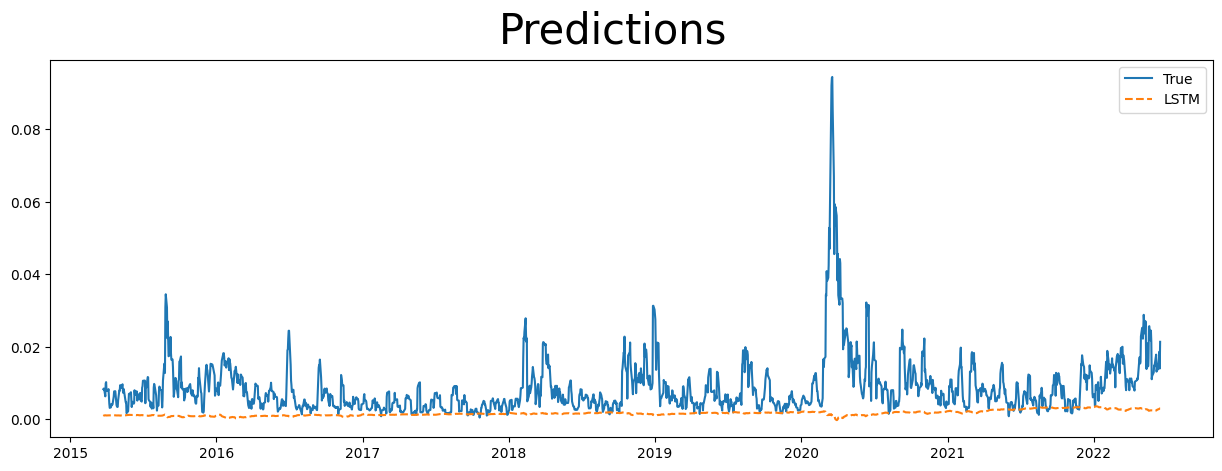

In [15]:
y_test_unscaled = y_test * volatility.max() + volatility.min()
y_test_plot = pd.Series(y_test_unscaled.squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

fig, ax = plt.subplots(len(metrics), 1, figsize=(15, 5 * len(metrics)), dpi=100)
fig.suptitle("Predictions", fontsize=30)

if len(metrics) > 1:
    for m in range(len(metrics)):
        model = list(models.keys())[m]
        model_name = list(metrics.keys())[m]
        y_pred_plot = pd.Series(predictions[model_name].squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

        ax[m].plot(y_test_plot, label='True')
        ax[m].plot(y_pred_plot, linestyle='--', label=model_name)
        ax[m].legend(loc=0)
        
elif len(metrics) == 1:
        model = list(models.keys())[0]
        model_name = list(metrics.keys())[0]
        y_pred_plot = pd.Series(predictions[model_name].squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

        ax.plot(y_test_plot, label='True')
        ax.plot(y_pred_plot, linestyle='--', label=model_name)
        ax.legend(loc=0)

plt.show()

NameError: name 'histories' is not defined

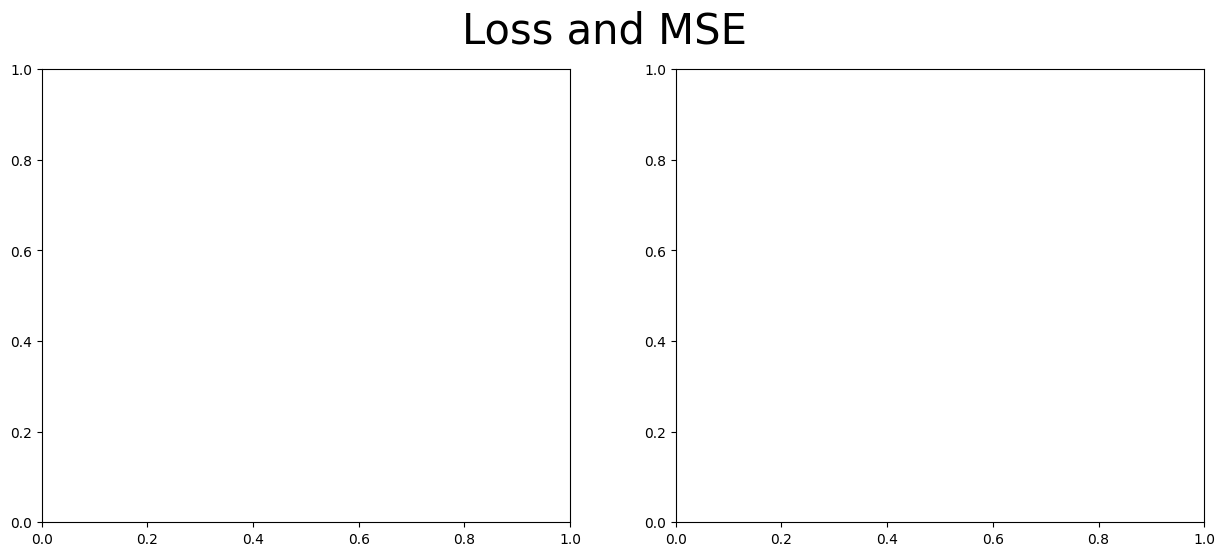

In [16]:
fig, ax = plt.subplots(len(metrics), 2, figsize=(15, 6 * len(metrics)), dpi=100)
fig.suptitle("Loss and MSE", fontsize=30)

if len(metrics) > 1:
    for m in range(len(metrics)):
        model = list(models.keys())[m]

        ax[m, 0].plot(histories[model]['loss'], color='b', label=f"{model} loss (training)")
        ax[m, 0].plot(histories[model]['val_loss'], color='g', label=f"{model} loss (validation)")
        ax[m, 0].legend(loc=0)

        ax[m, 1].plot(histories[model]['mse'], color='r', label=f"{model} MSE (training)")
        ax[m, 1].plot(histories[model]['val_mse'], color='y', label=f"{model} MSE (validation)")
        ax[m, 1].legend(loc=0)
elif len(metrics) == 1:
    model = list(models.keys())[0]

    ax[0].plot(histories[model]['loss'], color='b', label=f"{model} loss (training)")
    ax[0].plot(histories[model]['val_loss'], color='g', label=f"{model} loss (validation)")
    ax[0].legend(loc=0)

    ax[1].plot(histories[model]['mse'], color='r', label=f"{model} MSE (training)")
    ax[1].plot(histories[model]['val_mse'], color='y', label=f"{model} MSE (validation)")
    ax[1].legend(loc=0)

**Basic training:**

*Run 1:*
- mae = 0.01317; 
- mse = 0.00049; 
- msle = 0.00038; 
- mape = 26.38048%

*Run 2:*
- mae = 0.01490
- mse = 0.00056
- msle = 0.00042
- mape = 30.15045%

**Active learning:**

*Run 1:*
- mae = 0.01370
- mse = 0.00056
- msle = 0.00042
- mape = 27.88457%

*Run 2:*
- mae = 0.01782
- mse = 0.00098
- msle = 0.00065
- mape = 31.75339%
